## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.Starting a restaurant in toronto can be a great business opportunity, but you need to open it in a very good location.

## Business problem
Which neighbourhood in `Downtown Toronto` borough is best to open a restaurant?

## Data <a name="data"></a>
* Data source :- The data used in this analysis is gotten from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M it has the postal codes of each neighbourhood and the borough it falls under, I will also use the csv file provided in week 3 of this capstone it has the latitude and longitude of the neighbourhoods

* Based on definition of our problem, factors that will influence our decission are:
   * number of venues for travellers

In [1]:
import pandas as pd

In [14]:
data_2 = pd.read_csv('Geospatial_Coordinates.csv')
data_2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
data_1 = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
data_1.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [16]:
data = pd.merge(data, data_1, on = 'Postal Code')
data.head()

,Postal Code,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [17]:
#!pip install geopy
from geopy.geocoders import Nominatim

address = 'Toronto, CA'

geolocator = Nominatim(user_agent="hafsah")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


In [18]:
#latitude = data['Latitude']
#longitude = data['Longitude']
import folium
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#map_toronto

In [19]:
Downtown_Toronto_data = data[data['Borough'] == 'Downtown Toronto'].reset_index(drop=True) 
Downtown_Toronto_data.head()

,Postal Code,Latitude,Longitude,Borough,Neighbourhood
0,M4W,43.679563,-79.377529,Downtown Toronto,Rosedale
1,M4X,43.667967,-79.367675,Downtown Toronto,"St. James Town, Cabbagetown"
2,M4Y,43.665860,-79.383160,Downtown Toronto,Church and Wellesley
3,M5A,43.654260,-79.360636,Downtown Toronto,"Regent Park, Harbourfront"
4,M5B,43.657162,-79.378937,Downtown Toronto,"Garden District, Ryerson"


In [20]:
address = 'Downtown Toronto, CA'

geolocator = Nominatim(user_agent="hafsah")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, CA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, CA are 43.6563221, -79.3809161.


In [21]:
# create map of Manhattan using latitude and longitude values
map_Downtown_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Downtown_Toronto_data['Latitude'], Downtown_Toronto_data['Longitude'], Downtown_Toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown_Toronto)  
    
#map_Downtown_Toronto

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on Downtown Toronto Borough. We will limit our analysis to area ~5km around Borough center.

In first step we have collected the required **data: location and neighorhoods within 5km around Downtown Toronto Borough** . We have also **identified venues for travellers** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**number of venues for travellers in each neighorhoods**

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration neighorhoods with **more number of venues for travellers in each neighorhoods**, . We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

In [118]:
import requests
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                               )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [75]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'Y32R2HRIDDEAIMNPF3OT2QGLPQD3NQT2YOGAYPU0Y4SNVFR1' 
CLIENT_SECRET = 'EZJ3GHIVNVPWWKHBDNBRUY3NZJM2NUT3BXYDUPPGLN44N2MS' 
VERSION = '20180604'

In [76]:
#https://developer.foursquare.com/docs/resources/categories
#Sushi = 4bf58dd8d48988d1d2941735
Downtown_Toronto_Rest_Area = getNearbyVenues(names=Downtown_Toronto_data['Neighbourhood'], latitudes=Downtown_Toronto_data['Latitude'], longitudes=Downtown_Toronto_data['Longitude'], categoryIds='4d954b16a243a5684b65b473',radius=1000)
Downtown_Toronto_Rest_Area.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,the toilet at one king west,43.683295,-79.377917,Rest Area
1,"St. James Town, Cabbagetown",43.667967,-79.367675,gerrard and sherbourne,43.662749,-79.373612,Rest Area
2,Church and Wellesley,43.665860,-79.383160,Pervy Old Man,43.665176,-79.380375,Rest Area
3,Church and Wellesley,43.665860,-79.383160,Maryna's Car Nap,43.668789,-79.381805,Rest Area
4,Church and Wellesley,43.665860,-79.383160,gerrard and sherbourne,43.662749,-79.373612,Rest Area


In [54]:
Downtown_Toronto_Rest_Area['Neighborhood'].value_counts().idxmax()

'Church and Wellesley'

In [40]:
#https://developer.foursquare.com/docs/resources/categories
#Sushi = 4bf58dd8d48988d1d2941735
Downtown_Toronto_Vacation_Rental = getNearbyVenues(names=Downtown_Toronto_data['Neighbourhood'], latitudes=Downtown_Toronto_data['Latitude'], longitudes=Downtown_Toronto_data['Longitude'], radius=1000, categoryIds='56aa371be4b08b9a8d5734e1')
Downtown_Toronto_Vacation_Rental.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Atlas Suites - Mariner Terrace,43.639664,-79.392110,Vacation Rental
1,"University of Toronto, Harbord",43.662696,-79.400049,Annex Perfection,43.659547,-79.410268,Vacation Rental
2,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,Annex Perfection,43.659547,-79.410268,Vacation Rental
3,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,Atlas Suites - Mariner Terrace,43.639664,-79.392110,Vacation Rental
4,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,Airbnb Ben’s House,43.639898,-79.396736,Vacation Rental


In [55]:
Downtown_Toronto_Vacation_Rental['Neighborhood'].value_counts().idxmax()

'CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport'

In [42]:
#https://developer.foursquare.com/docs/resources/categories
#Sushi = 4bf58dd8d48988d1d2941735
Downtown_Toronto_Travel_Lounge = getNearbyVenues(names=Downtown_Toronto_data['Neighbourhood'], latitudes=Downtown_Toronto_data['Latitude'], longitudes=Downtown_Toronto_data['Longitude'], radius=1000, categoryIds='4f04b25d2fb6e1c99f3db0c0')
Downtown_Toronto_Travel_Lounge.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,motel deeps,43.652945,-79.369103,Travel Lounge
1,"Garden District, Ryerson",43.657162,-79.378937,Executive Lounge Toronto Marriott Eaton Centre,43.654903,-79.382884,Travel Lounge
2,"Garden District, Ryerson",43.657162,-79.378937,motel deeps,43.652945,-79.369103,Travel Lounge
3,"Garden District, Ryerson",43.657162,-79.378937,BYNB*116 Lamborghini,43.653162,-79.376537,Travel Lounge
4,St. James Town,43.651494,-79.375418,Executive Lounge Toronto Marriott Eaton Centre,43.654903,-79.382884,Travel Lounge


In [56]:
Downtown_Toronto_Travel_Lounge['Neighborhood'].value_counts().idxmax()

'Commerce Court, Victoria Hotel'

In [104]:
social = pd.concat([Downtown_Toronto_Rest_Area, Downtown_Toronto_Vacation_Rental, Downtown_Toronto_Travel_Lounge,])

In [105]:
social

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,the toilet at one king west,43.683295,-79.377917,Rest Area
1,"St. James Town, Cabbagetown",43.667967,-79.367675,gerrard and sherbourne,43.662749,-79.373612,Rest Area
2,Church and Wellesley,43.665860,-79.383160,Pervy Old Man,43.665176,-79.380375,Rest Area
3,Church and Wellesley,43.665860,-79.383160,Maryna's Car Nap,43.668789,-79.381805,Rest Area
4,Church and Wellesley,43.665860,-79.383160,gerrard and sherbourne,43.662749,-79.373612,Rest Area
5,Church and Wellesley,43.665860,-79.383160,Scooter Parking Spot [Betsey],43.669529,-79.390647,Rest Area
6,"Garden District, Ryerson",43.657162,-79.378937,gerrard and sherbourne,43.662749,-79.373612,Rest Area
7,"Garden District, Ryerson",43.657162,-79.378937,#416insomnia,43.645811,-79.377318,Rest Area
8,"Garden District, Ryerson",43.657162,-79.378937,Pervy Old Man,43.665176,-79.380375,Rest Area
9,St. James Town,43.651494,-79.375418,#416insomnia,43.645811,-79.377318,Rest Area


## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the  **number of venues for travellers in Neighborhood**

In [145]:
social['Neighborhood'].value_counts()

Commerce Court, Victoria Hotel                                                                                11
St. James Town                                                                                                10
Stn A PO Boxes                                                                                                10
Toronto Dominion Centre, Design Exchange                                                                       9
First Canadian Place, Underground city                                                                         9
Berczy Park                                                                                                    9
Richmond, Adelaide, King                                                                                       9
Harbourfront East, Union Station, Toronto Islands                                                              7
Garden District, Ryerson                                                                        

In [150]:
saf = pd.DataFrame(social['Neighborhood'].value_counts())
saf.reindex(columns = ['number of venues for travellers in Neighborhood'])
saf

,Neighborhood
"Commerce Court, Victoria Hotel",11
St. James Town,10
Stn A PO Boxes,10
"Toronto Dominion Centre, Design Exchange",9
"First Canadian Place, Underground city",9
Berczy Park,9
"Richmond, Adelaide, King",9
"Harbourfront East, Union Station, Toronto Islands",7
"Garden District, Ryerson",6
Church and Wellesley,4


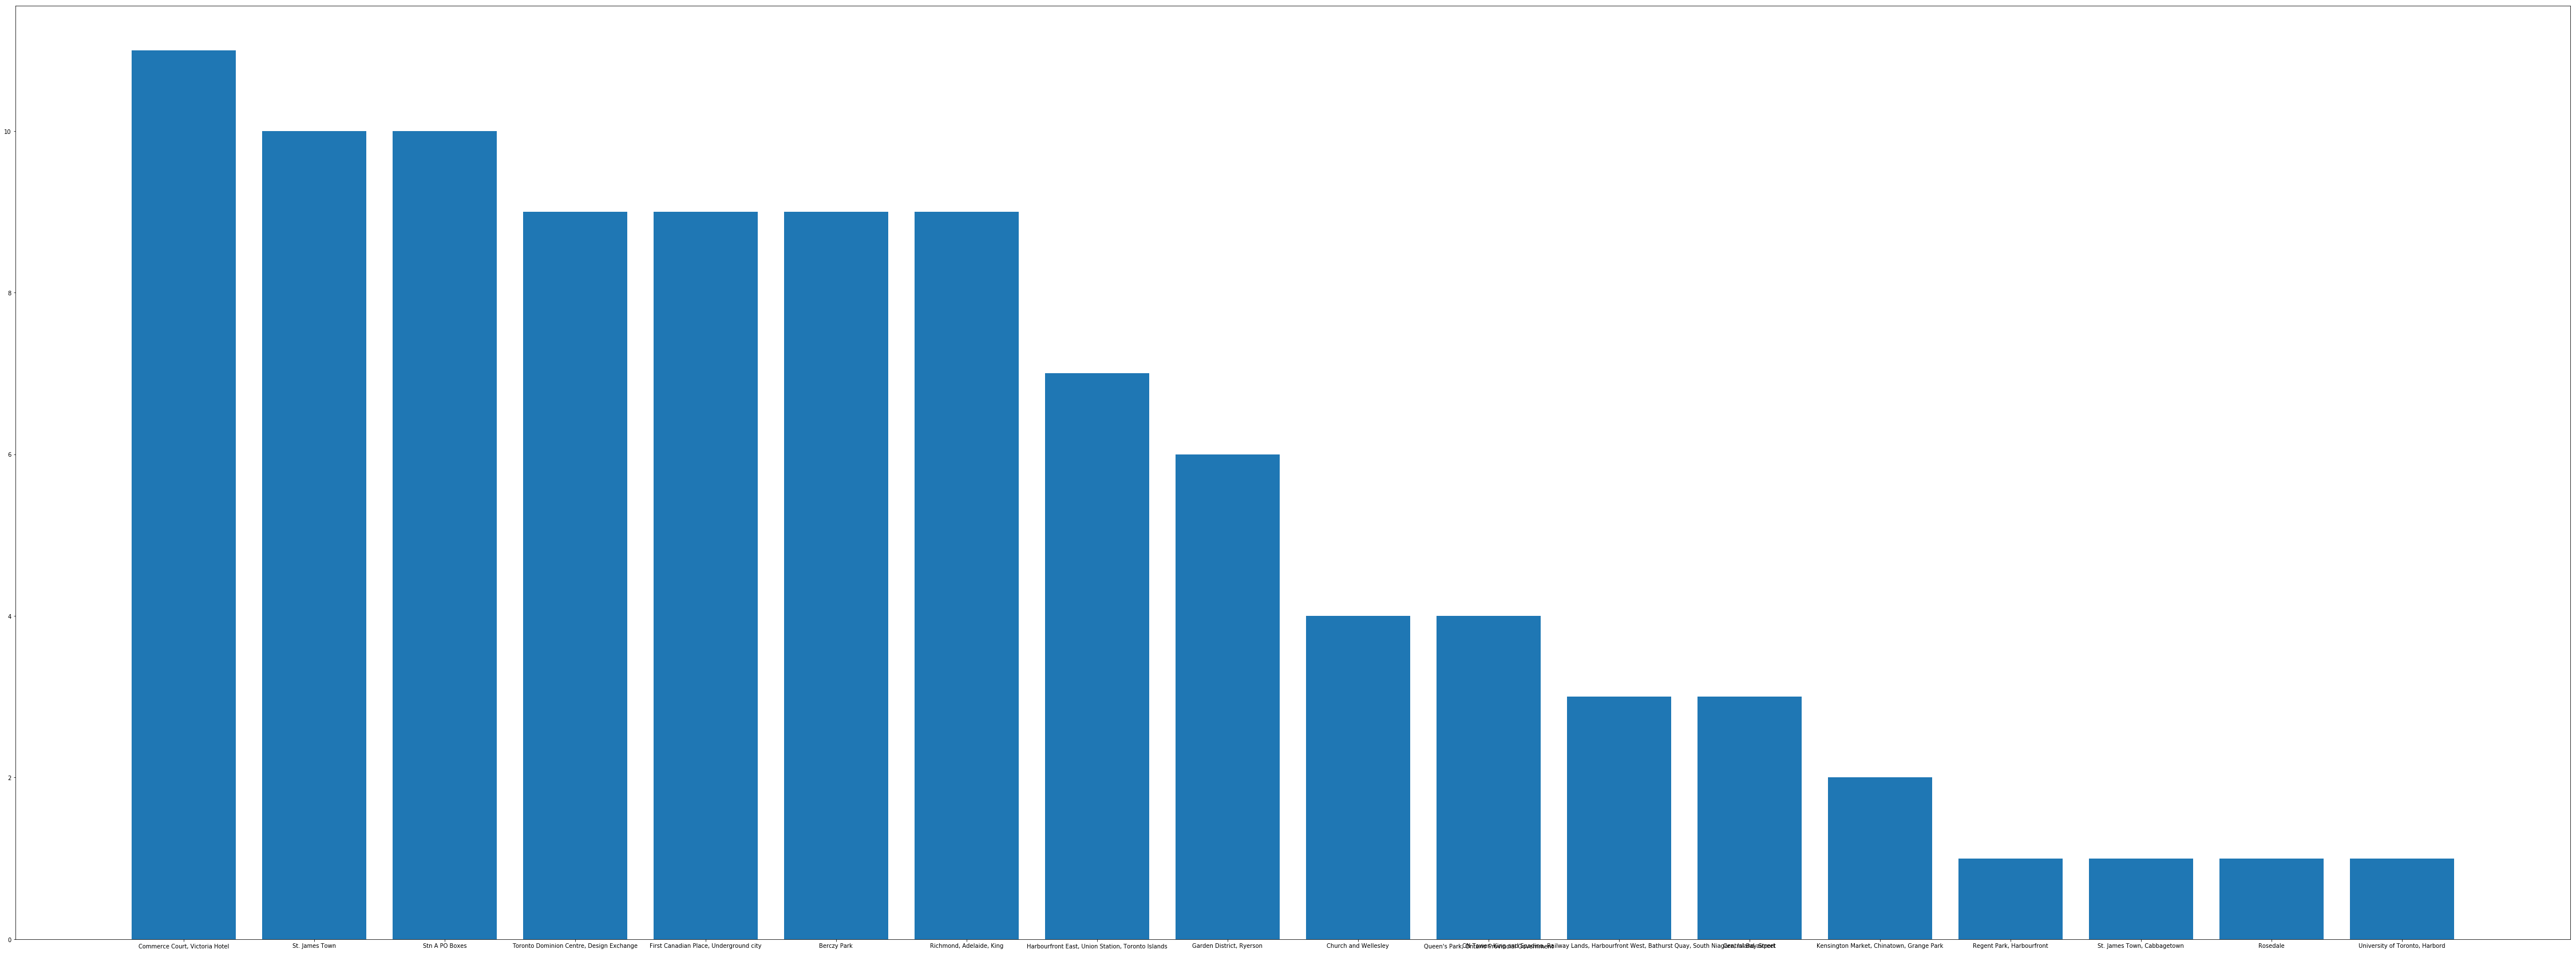

In [159]:
import matplotlib.pyplot as plts
plts.figure(figsize=(80,30))
plts.bar(saf.index,saf['Neighborhood'])
plts.show()

In [107]:
import folium
# create map of Toronto using latitude and longitude values
map_Downtown_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng,neighborhood in zip(social['Neighborhood Latitude'], social['Neighborhood Longitude'], social['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown_Toronto) 


    
map_Downtown_Toronto.save('a.html')

## Cluster Neighbourhoods

In [120]:
Downtown_Toronto_onehot = pd.get_dummies(social[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Downtown_Toronto_onehot['Neighbourhood'] = social['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Downtown_Toronto_onehot.columns[-1]] + list(Downtown_Toronto_onehot.columns[:-1])
Downtown_Toronto_onehot = Downtown_Toronto_onehot[fixed_columns]
Downtown_Toronto_grouped = Downtown_Toronto_onehot.groupby('Neighbourhood').mean().reset_index()

In [121]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

Downtown_Toronto_grouped_clustering = Downtown_Toronto_grouped.drop('Neighbourhood', axis =1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Downtown_Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 3, 0, 1, 1, 3, 1, 4, 0])

In [122]:
num_top_venues = 5

for hood in Downtown_Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Downtown_Toronto_grouped[Downtown_Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0       Travel Lounge  0.78
1           Rest Area  0.22
2  Airport Food Court  0.00
3     Vacation Rental  0.00


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0     Vacation Rental  0.67
1  Airport Food Court  0.33
2           Rest Area  0.00
3       Travel Lounge  0.00


----Central Bay Street----
                venue  freq
0       Travel Lounge  0.67
1           Rest Area  0.33
2  Airport Food Court  0.00
3     Vacation Rental  0.00


----Church and Wellesley----
                venue  freq
0           Rest Area   1.0
1  Airport Food Court   0.0
2       Travel Lounge   0.0
3     Vacation Rental   0.0


----Commerce Court, Victoria Hotel----
                venue  freq
0       Travel Lounge  0.82
1           Rest Area  0.18
2  Airport Food Court  0.00
3     Vacation Rental  0.00


----First Canadian Place, Underground city----
             

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [129]:
import numpy as np
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Downtown_Toronto_grouped['Neighbourhood']

for ind in np.arange(Downtown_Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_Toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Berczy Park,Travel Lounge,Rest Area,Vacation Rental,Airport Food Court
1,"CN Tower, King and Spadina, Railway Lands, Har...",Vacation Rental,Airport Food Court,Travel Lounge,Rest Area
2,Central Bay Street,Travel Lounge,Rest Area,Vacation Rental,Airport Food Court
3,Church and Wellesley,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court
4,"Commerce Court, Victoria Hotel",Travel Lounge,Rest Area,Vacation Rental,Airport Food Court


In [130]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Downtown_Toronto_merged = social

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Downtown_Toronto_merged = Downtown_Toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighborhood')

Downtown_Toronto_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Rosedale,43.679563,-79.377529,the toilet at one king west,43.683295,-79.377917,Rest Area,0,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court
1,"St. James Town, Cabbagetown",43.667967,-79.367675,gerrard and sherbourne,43.662749,-79.373612,Rest Area,0,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court
2,Church and Wellesley,43.665860,-79.383160,Pervy Old Man,43.665176,-79.380375,Rest Area,0,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court
3,Church and Wellesley,43.665860,-79.383160,Maryna's Car Nap,43.668789,-79.381805,Rest Area,0,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court
4,Church and Wellesley,43.665860,-79.383160,gerrard and sherbourne,43.662749,-79.373612,Rest Area,0,Rest Area,Vacation Rental,Travel Lounge,Airport Food Court


In [133]:
import matplotlib as plt
import matplotlib.cm
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [plt.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Downtown_Toronto_merged['Neighborhood Latitude'], Downtown_Toronto_merged['Neighborhood Longitude'], Downtown_Toronto_merged['Neighborhood'], Downtown_Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('s.html')

In [135]:
Downtown_Toronto_merged['Neighborhood'].value_counts()

Commerce Court, Victoria Hotel                                                                                11
St. James Town                                                                                                10
Stn A PO Boxes                                                                                                10
Toronto Dominion Centre, Design Exchange                                                                       9
First Canadian Place, Underground city                                                                         9
Berczy Park                                                                                                    9
Richmond, Adelaide, King                                                                                       9
Harbourfront East, Union Station, Toronto Islands                                                              7
Garden District, Ryerson                                                                        